In [31]:
import pandas as pd
import os
import s3fs
import warnings
from datetime import date, timedelta, datetime
import numpy as np
import matplotlib.pyplot as plt

In [32]:
exec(open('../../0_KPI_functions.py').read())

In [33]:
# Ignore warning
warnings.filterwarnings('ignore')

# Statistiques descriptives : compagnies sport

## Importations et chargement des données

In [34]:
# Create filesystem object
S3_ENDPOINT_URL = "https://" + os.environ["AWS_S3_ENDPOINT"]
fs = s3fs.S3FileSystem(client_kwargs={'endpoint_url': S3_ENDPOINT_URL})

In [35]:
# création des bases contenant les KPI pour les 5 compagnies de spectacle

# liste des compagnies de spectacle
nb_compagnie=['5','6','7','8','9']

customer_sport = pd.DataFrame()
campaigns_sport = pd.DataFrame()
products_sport = pd.DataFrame()
tickets_sport = pd.DataFrame()

# début de la boucle permettant de générer des datasets agrégés pour les 5 compagnies de spectacle
for directory_path in nb_compagnie:
    df_customerplus_clean_0 = display_databases(directory_path, file_name = "customerplus_cleaned")
    df_campaigns_information = display_databases(directory_path, file_name = "campaigns_information", datetime_col = ['opened_at', 'sent_at', 'campaign_sent_at'])
    df_products_purchased_reduced = display_databases(directory_path, file_name = "products_purchased_reduced", datetime_col = ['purchase_date'])
    df_target_information = display_databases(directory_path, file_name = "target_information")
    
    df_campaigns_kpi = campaigns_kpi_function(campaigns_information = df_campaigns_information) 
    df_tickets_kpi = tickets_kpi_function(tickets_information = df_products_purchased_reduced)
    df_customerplus_clean = customerplus_kpi_function(customerplus_clean = df_customerplus_clean_0)

        
# creation de la colonne Number compagnie, qui permettra d'agréger les résultats
    df_tickets_kpi["number_company"]=int(directory_path)
    df_campaigns_kpi["number_company"]=int(directory_path)
    df_customerplus_clean["number_company"]=int(directory_path)
    df_target_information["number_company"]=int(directory_path)

# Traitement des index
    df_tickets_kpi["customer_id"]= directory_path + '_' +  df_tickets_kpi['customer_id'].astype('str')
    df_campaigns_kpi["customer_id"]= directory_path + '_' +  df_campaigns_kpi['customer_id'].astype('str') 
    df_customerplus_clean["customer_id"]= directory_path + '_' +  df_customerplus_clean['customer_id'].astype('str') 
    df_products_purchased_reduced["customer_id"]= directory_path + '_' +  df_products_purchased_reduced['customer_id'].astype('str') 

# Concaténation
    customer_sport = pd.concat([customer_sport, df_customerplus_clean], ignore_index=True)
    campaigns_sport = pd.concat([campaigns_sport, df_campaigns_kpi], ignore_index=True)
    tickets_sport = pd.concat([tickets_sport, df_tickets_kpi], ignore_index=True)
    products_sport = pd.concat([products_sport, df_products_purchased_reduced], ignore_index=True)
    

File path :  projet-bdc2324-team1/0_Input/Company_5/customerplus_cleaned.csv
File path :  projet-bdc2324-team1/0_Input/Company_5/campaigns_information.csv
File path :  projet-bdc2324-team1/0_Input/Company_5/products_purchased_reduced.csv
File path :  projet-bdc2324-team1/0_Input/Company_5/target_information.csv
File path :  projet-bdc2324-team1/0_Input/Company_6/customerplus_cleaned.csv
File path :  projet-bdc2324-team1/0_Input/Company_6/campaigns_information.csv
File path :  projet-bdc2324-team1/0_Input/Company_6/products_purchased_reduced.csv
File path :  projet-bdc2324-team1/0_Input/Company_6/target_information.csv
File path :  projet-bdc2324-team1/0_Input/Company_7/customerplus_cleaned.csv
File path :  projet-bdc2324-team1/0_Input/Company_7/campaigns_information.csv
File path :  projet-bdc2324-team1/0_Input/Company_7/products_purchased_reduced.csv
File path :  projet-bdc2324-team1/0_Input/Company_7/target_information.csv
File path :  projet-bdc2324-team1/0_Input/Company_8/customerp

## Statistiques descriptives

### 0. Détection du client anonyme (outlier) - utile pour la section 3

In [36]:
sport_comp = tickets_sport['number_company'].unique()
sport_comp

array([5, 6, 7, 8, 9])

In [37]:
def outlier_detection(company_list, show_diagram=False):

    outlier_list = list()
    
    for company in company_list:
        total_amount_share = tickets_sport[tickets_sport['number_company']==company].groupby('customer_id')['total_amount'].sum().reset_index()
        total_amount_share['CA'] = total_amount_share['total_amount'].sum()
        total_amount_share['share_total_amount'] = total_amount_share['total_amount']/total_amount_share['CA']
        
        total_amount_share_index = total_amount_share.set_index('customer_id')
        df_circulaire = total_amount_share_index['total_amount'].sort_values(axis = 0, ascending = False)
        top = df_circulaire[:1]
        outlier_list.append(top.index[0])
        rest = df_circulaire[1:]
    
        # Calculez la somme du reste
        rest_sum = rest.sum()
        
        # Créez une nouvelle série avec les cinq plus grandes parts et 'Autre'
        new_series = pd.concat([top, pd.Series([rest_sum], index=['Autre'])])
        
        # Créez le graphique circulaire
        if show_diagram:
            plt.figure(figsize=(3, 3))
            plt.pie(new_series, labels=new_series.index, autopct='%1.1f%%', startangle=140, pctdistance=0.5)
            plt.axis('equal')  # Assurez-vous que le graphique est un cercle
            plt.title(f'Répartition des montants totaux pour la compagnie {company}')
            plt.show()
    return outlier_list
    

In [38]:
outlier_list = outlier_detection(sport_comp)
outlier_list

['5_191835', '6_591412', '7_49632', '8_1942', '9_19683']

In [39]:
# On filtre les outliers

def remove_elements(lst, elements_to_remove):
    return ''.join([x for x in lst if x not in elements_to_remove])
    
databases = [customer_sport, campaigns_sport, tickets_sport, products_sport]

for dataset in databases:
    dataset['customer_id'] = dataset['customer_id'].apply(lambda x: remove_elements(x, outlier_list))

# On test

bool = '5_191835' in customer_sport['customer_id']
if not bool:
    print("Suppression Réussie")

Suppression Réussie


In [40]:
customer_sport.head()

customer_id  street_id  structure_id  mcp_contact_id  fidelity  tenant_id  \
0   5_6009745    1372685           NaN             NaN         0       1771   
1   5_6011228    1372685           NaN             NaN         0       1771   
2   5_6058950    1372685           NaN             NaN         0       1771   
3   5_6062404    1372685           NaN             NaN         0       1771   
4    5_250217      78785           NaN         11035.0         0       1771   

   is_partner  deleted_at  gender  is_email_true  ...  purchase_count  \
0       False         NaN       2           True  ...               0   
1       False         NaN       2           True  ...               0   
2       False         NaN       2           True  ...               0   
3       False         NaN       2           True  ...               0   
4       False         NaN       0           True  ...               0   

  first_buying_date  country  gender_label  gender_female  gender_male  \
0               NaN       af         other              0            0   
1               NaN       af         other              0            0   
2               NaN       af         other              0            0   
3               NaN       af         other              0            0   
4               NaN       fr        female              1            0   

   gender_other  country_fr  has_tags  number_company  
0             1         0.0         0               5  
1             1         0.0         0               5  
2             1         0.0         0               5  
3             1         0.0         0               5  
4             0         1.0         0               5  

[5 rows x 29 columns]

### 1. customerplus_clean

In [45]:
def compute_nb_clients(customer_sport):
    company_nb_clients = customer_sport[customer_sport["purchase_count"]>0].groupby("number_company")["customer_id"].count().reset_index()
    plt.bar(company_nb_clients["number_company"], company_nb_clients["customer_id"]/1000)

    # Ajout de titres et d'étiquettes
    plt.xlabel('Company')
    plt.ylabel("Nombre de clients (milliers)")
    plt.title("Nombre de clients de chaque compagnie de sport")
    
    # Affichage du barplot
    plt.show()

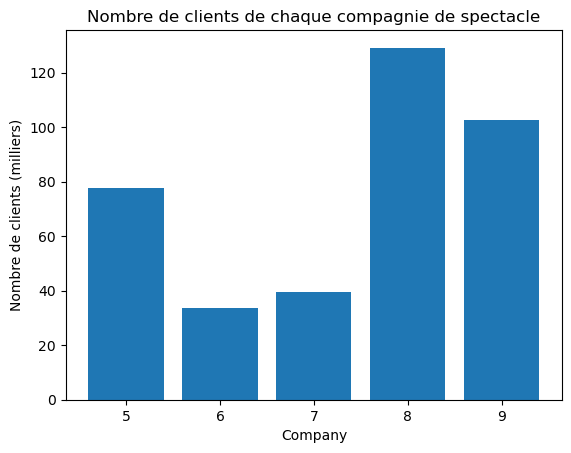

In [46]:
compute_nb_clients(customer_sport)

In [47]:
def maximum_price_paid(customer_sport):
    company_max_price = customer_sport.groupby("number_company")["max_price"].max().reset_index()
    # Création du barplot
    plt.bar(company_max_price["number_company"], company_max_price["max_price"])
    
    # Ajout de titres et d'étiquettes
    plt.xlabel('Company')
    plt.ylabel("Prix maximal d'un billet vendu")
    plt.title("Prix maximal de vente observé par compagnie de sport")
    
    # Affichage du barplot
    plt.show()

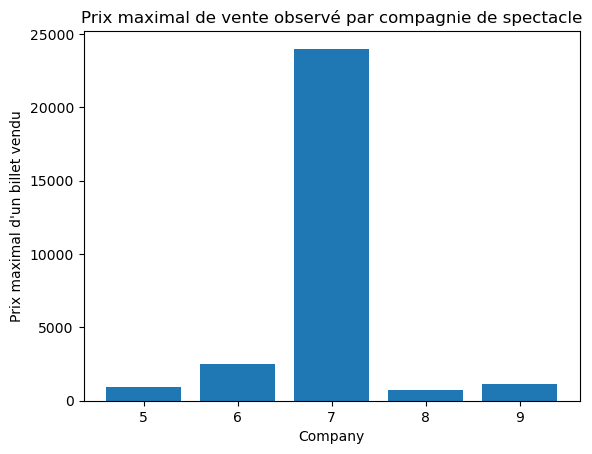

In [48]:
maximum_price_paid(customer_sport)

In [49]:
for company in sport_comp:
    print(f'Statistiques Descriptives company {company}')
    company_data = customer_sport[customer_sport['number_company'] == company][['average_price', 'average_price_basket',
          'average_ticket_basket', 'purchase_count', 'total_price']]
    print(company_data.describe())

Statistiques Descriptives company 5
       average_price  average_price_basket  average_ticket_basket  \
count  145390.000000          68869.000000           68869.000000   
mean       11.070309             65.969693               3.655202   
std        16.353610            195.462869              13.119612   
min         0.000000              0.000000               1.000000   
25%         0.000000             20.000000               1.000000   
50%         0.000000             45.000000               2.000000   
75%        20.000000             79.500000               3.000000   
max       500.000000          24159.405000            2139.833333   

       purchase_count   total_price  
count    471598.00000  3.950770e+05  
mean          0.29900  2.608544e+01  
std           7.22753  2.089636e+03  
min           0.00000  0.000000e+00  
25%           0.00000  0.000000e+00  
50%           0.00000  0.000000e+00  
75%           0.00000  0.000000e+00  
max        3532.00000  1.262516e+06  


In [50]:
customer_sport["already_purchased"] = customer_sport["purchase_count"] > 0

In [52]:
def mailing_consent(customer_sport):
    df_graph = customer_sport.groupby(["number_company", "already_purchased"])["opt_in"].mean().reset_index()
    # Création du barplot groupé
    fig, ax = plt.subplots(figsize=(10, 6))
    
    categories = df_graph["number_company"].unique()
    bar_width = 0.35
    bar_positions = np.arange(len(categories))
    
    # Grouper les données par label et créer les barres groupées
    for label in df_graph["already_purchased"].unique():
        label_data = df_graph[df_graph['already_purchased'] == label]
        values = [label_data[label_data['number_company'] == category]['opt_in'].values[0]*100 for category in categories]
    
        label_printed = "purchased" if label else "no purchase"
        ax.bar(bar_positions, values, bar_width, label=label_printed)
    
        # Mise à jour des positions des barres pour le prochain groupe
        bar_positions = [pos + bar_width for pos in bar_positions]
    
    # Ajout des étiquettes, de la légende, etc.
    ax.set_xlabel('Numero de compagnie')
    ax.set_ylabel('Part de consentement (%)')
    ax.set_title('Part de consentement au mailing selon les compagnies')
    ax.set_xticks([pos + bar_width / 2 for pos in np.arange(len(categories))])
    ax.set_xticklabels(categories)
    ax.legend()
    
    # Affichage du plot
    plt.show()

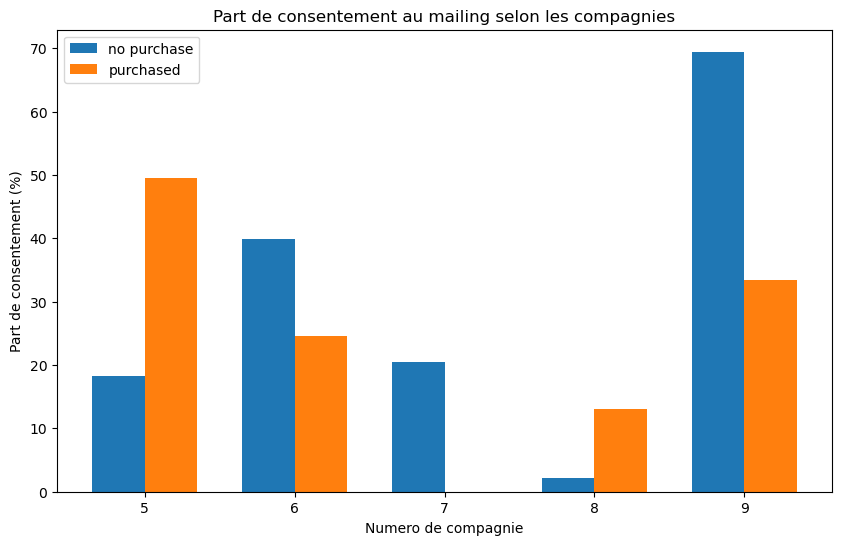

In [54]:
mailing_consent(customer_sport)

In [56]:
def gender_bar(customer_sport):
    company_genders = customer_sport.groupby("number_company")[["gender_male", "gender_female", "gender_other"]].mean().reset_index()
    # Création du barplot
    plt.bar(company_genders["number_company"], company_genders["gender_male"], label = "Homme")
    plt.bar(company_genders["number_company"], company_genders["gender_female"], 
            bottom = company_genders["gender_male"], label = "Femme")
    
    
    # Ajout de titres et d'étiquettes
    plt.xlabel('Company')
    plt.ylabel("Part de clients de chaque sexe")
    plt.title("Sexe des clients de chaque compagnie de sport")
    plt.legend()
    
    # Affichage du barplot
    plt.show()

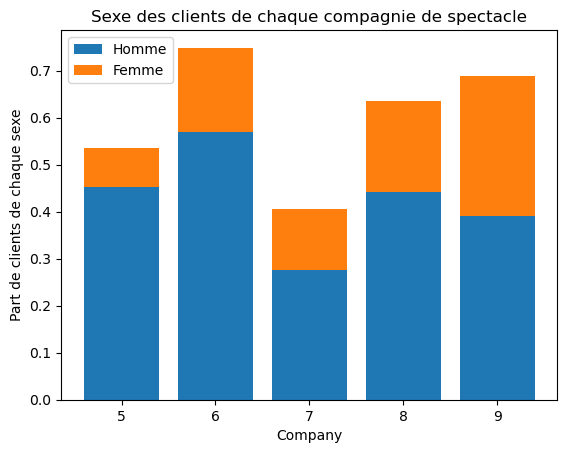

In [57]:
gender_bar(customer_sport)

In [62]:
def country_bar(customer_sport):
    company_country_fr = customer_sport.groupby("number_company")["country_fr"].mean().reset_index()
    # Création du barplot
    plt.bar(company_country_fr["number_company"], company_country_fr["country_fr"])
    
    # Ajout de titres et d'étiquettes
    plt.xlabel('Company')
    plt.ylabel("Part de clients français")
    plt.title("Nationalité des clients de chaque compagnie de sport")
    
    # Affichage du barplot
    plt.show()

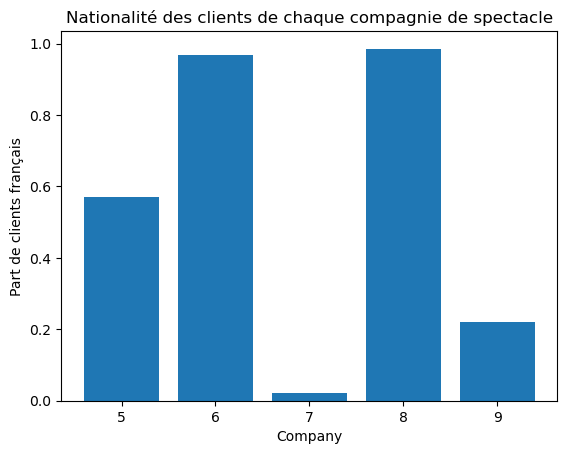

In [63]:
country_bar(customer_sport)

### 2. campaigns_information

In [66]:
print("Nombre de lignes de la table : ",campaigns_sport.shape[0])
campaigns_sport.isna().sum()

Nombre de lignes de la table :  463098


customer_id                 0
nb_campaigns                0
nb_campaigns_opened         0
time_to_open           178826
number_company              0
dtype: int64

In [72]:
campaigns_sport["no_campaign_opened"] = pd.isna(campaigns_sport["time_to_open"])
company_lazy_customers = campaigns_sport.groupby("number_company")["no_campaign_opened"].mean().reset_index()

def lazy_customer_plot(campaigns_sport):
    company_lazy_customers = campaigns_sport.groupby("number_company")["no_campaign_opened"].mean().reset_index()
    # Création du barplot
    plt.bar(company_lazy_customers["number_company"], company_lazy_customers["no_campaign_opened"])
    
    # Ajout de titres et d'étiquettes
    plt.xlabel('Company')
    plt.ylabel("Part de clients n'ayant ouvert aucun mail")
    plt.title("Part de clients n'ayant ouvert aucun mail pour les compagnies de sport")
    
    # Affichage du barplot
    plt.show()

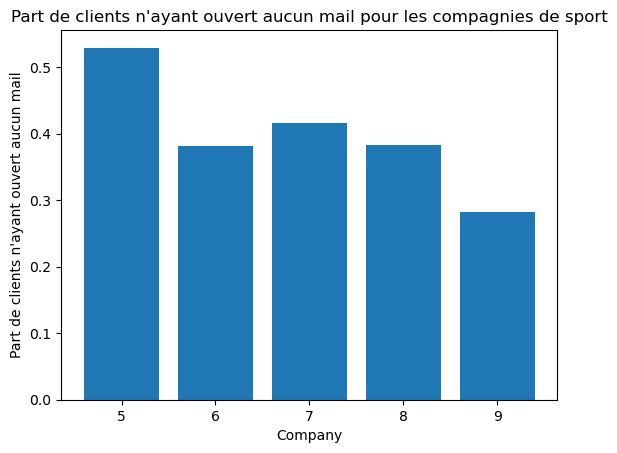

In [73]:
lazy_customer_plot(campaigns_sport)